<a href="https://colab.research.google.com/github/ChandrimaDam/CVPR/blob/main/Stock_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
dataset_path = "/content/drive/MyDrive/Stock_Project_Dataset"

# List all CSV files
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
csv_files

['META_monthly.csv',
 'GOOGLE_monthly.csv',
 'APPLE_monthly.csv',
 'META_weekly.csv',
 'NETFLIX_monthly.csv',
 'AMAZON_monthly.csv',
 'GOOGLE_weekly.csv',
 'AMAZON_weekly.csv',
 'NETFLIX_weekly.csv',
 'APPLE_weekly.csv',
 'META_daily.csv',
 'GOOGLE_daily.csv',
 'NETFLIX_daily.csv',
 'AMAZON_daily.csv',
 'APPLE_daily.csv']

In [5]:
import pandas as pd
import os

dataset_path = "/content/drive/MyDrive/Stock_Project_Dataset"
file_name = "GOOGLE_daily.csv"
file_path = os.path.join(dataset_path, file_name)

df = pd.read_csv(file_path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.472123,2.572491,2.372250,2.480529,897427216,2.480529
1,2004-08-20,2.497091,2.696592,2.484484,2.677557,458857488,2.677557
2,2004-08-23,2.737876,2.805365,2.695851,2.704503,366857939,2.704503
3,2004-08-24,2.749990,2.758889,2.560378,2.592515,306396159,2.592515
4,2004-08-25,2.594740,2.669894,2.568041,2.620450,184645512,2.620450


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()

In [7]:
print(df.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [8]:
df.columns = df.columns.str.strip()

In [9]:
df = df.ffill()
df = df.bfill()
df = df.fillna(df.median())

In [10]:
df['Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Volatility'] = df['High'] - df['Low']
df['Momentum'] = df['Close'] - df['Close'].shift(5)

df.dropna(inplace=True)

In [11]:
features = [
    'Open','High','Low','Close','Volume',
    'Return','Log_Return','Volatility','Momentum'
]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [12]:
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 3])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window=30)

In [13]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [14]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),

    LSTM(64),
    Dropout(0.2),

    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - loss: 0.0018 - val_loss: 1.1461e-04
Epoch 2/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.0229e-04 - val_loss: 2.3380e-04
Epoch 3/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 9.1305e-05 - val_loss: 1.0454e-04
Epoch 4/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 6.0792e-05 - val_loss: 3.0293e-04
Epoch 5/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 5.2484e-05 - val_loss: 2.4759e-04
Epoch 6/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 4.7986e-05 - val_loss: 1.0928e-04
Epoch 7/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 4.8141e-05 - val_loss: 5.1394e-04
Epoch 8/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 4.6680e-05 - val_loss: 1.2019e-04
Epoch 9/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 4.2235e-05 - val_loss: 3.9027e-04
Epoch 10/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 4.5742e-05 - val_loss: 9.3812e-05
Epoch 11/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/s

In [16]:
pred = model.predict(X_test)

close_scaler = MinMaxScaler()
close_scaler.fit(df[['Close']])

predicted = close_scaler.inverse_transform(pred)
actual = close_scaler.inverse_transform(y_test.reshape(-1,1))

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [17]:
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 6.576185687369199
MAE: 4.401559740915423


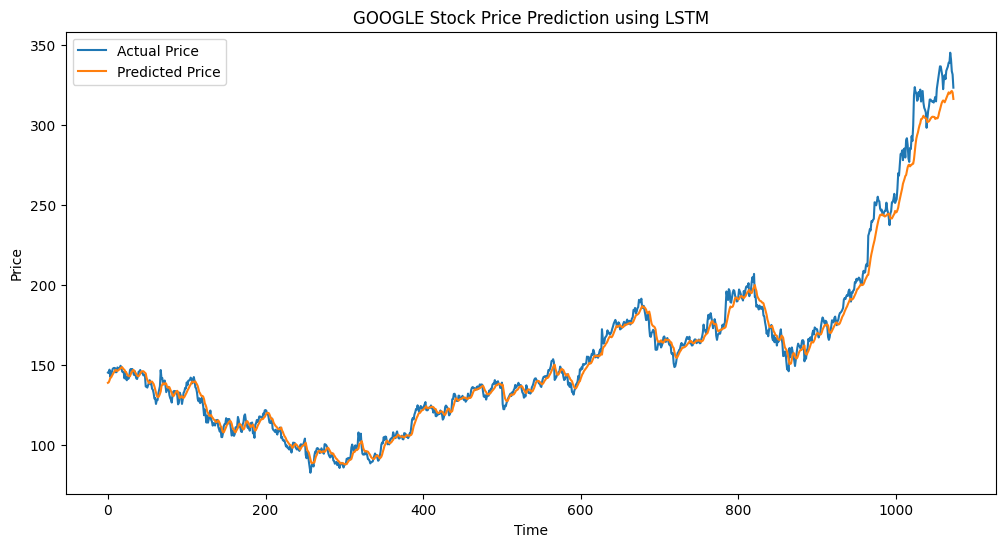

In [18]:
plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.title('GOOGLE Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()